In [10]:
# Imports - run first
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc("pdf", fonttype=42)

from geoscripts.dz import dz

samples_published = dz.load_all()

samples_new = dz.load_all('UCD22/')


samples = samples_published + samples_new

In [11]:
nickname_dic = {'CT15076':'KZ1','CT15082':'KZ2','CT15092':'KZ3','CT15099':'KZ4','CT15127':'KZ5','CT15113':'KZ6','AB0913':'RU1','CT130918-2A':'SV1',
'100211-9A':'SV2','CT130918-9A':'SV3','CT130919-5A':'SV4','100411-5':'SV5','CT130919-8A':'SV6','AB0926':'SV7','100211-1A':'SV8'}

for smp in samples:
    if smp.name in nickname_dic:
        smp.original = smp.name
        smp.name = nickname_dic[smp.name]

        # Purge erroneous ages
        smp.bestage = smp.bestage[smp.bestage>1]

        print(smp.name,smp.original)

SV8 100211-1A
SV2 100211-9A
SV5 100411-5
RU1 AB0913
SV7 AB0926
SV1 CT130918-2A
SV3 CT130918-9A
SV4 CT130919-5A
SV6 CT130919-8A
KZ1 CT15076
KZ2 CT15082
KZ3 CT15092
KZ4 CT15099
KZ6 CT15113
KZ5 CT15127


In [12]:
kz_samples = [smp for smp in samples if 'KZ' in smp.name]
kz_samples.sort(key=lambda x: x.name, reverse=True)
sv_samples = [smp for smp in samples if 'SV' in smp.name]
sv_samples.sort(key=lambda x: x.name, reverse=True)

ru = [smp for smp in samples if 'RU' in smp.name]

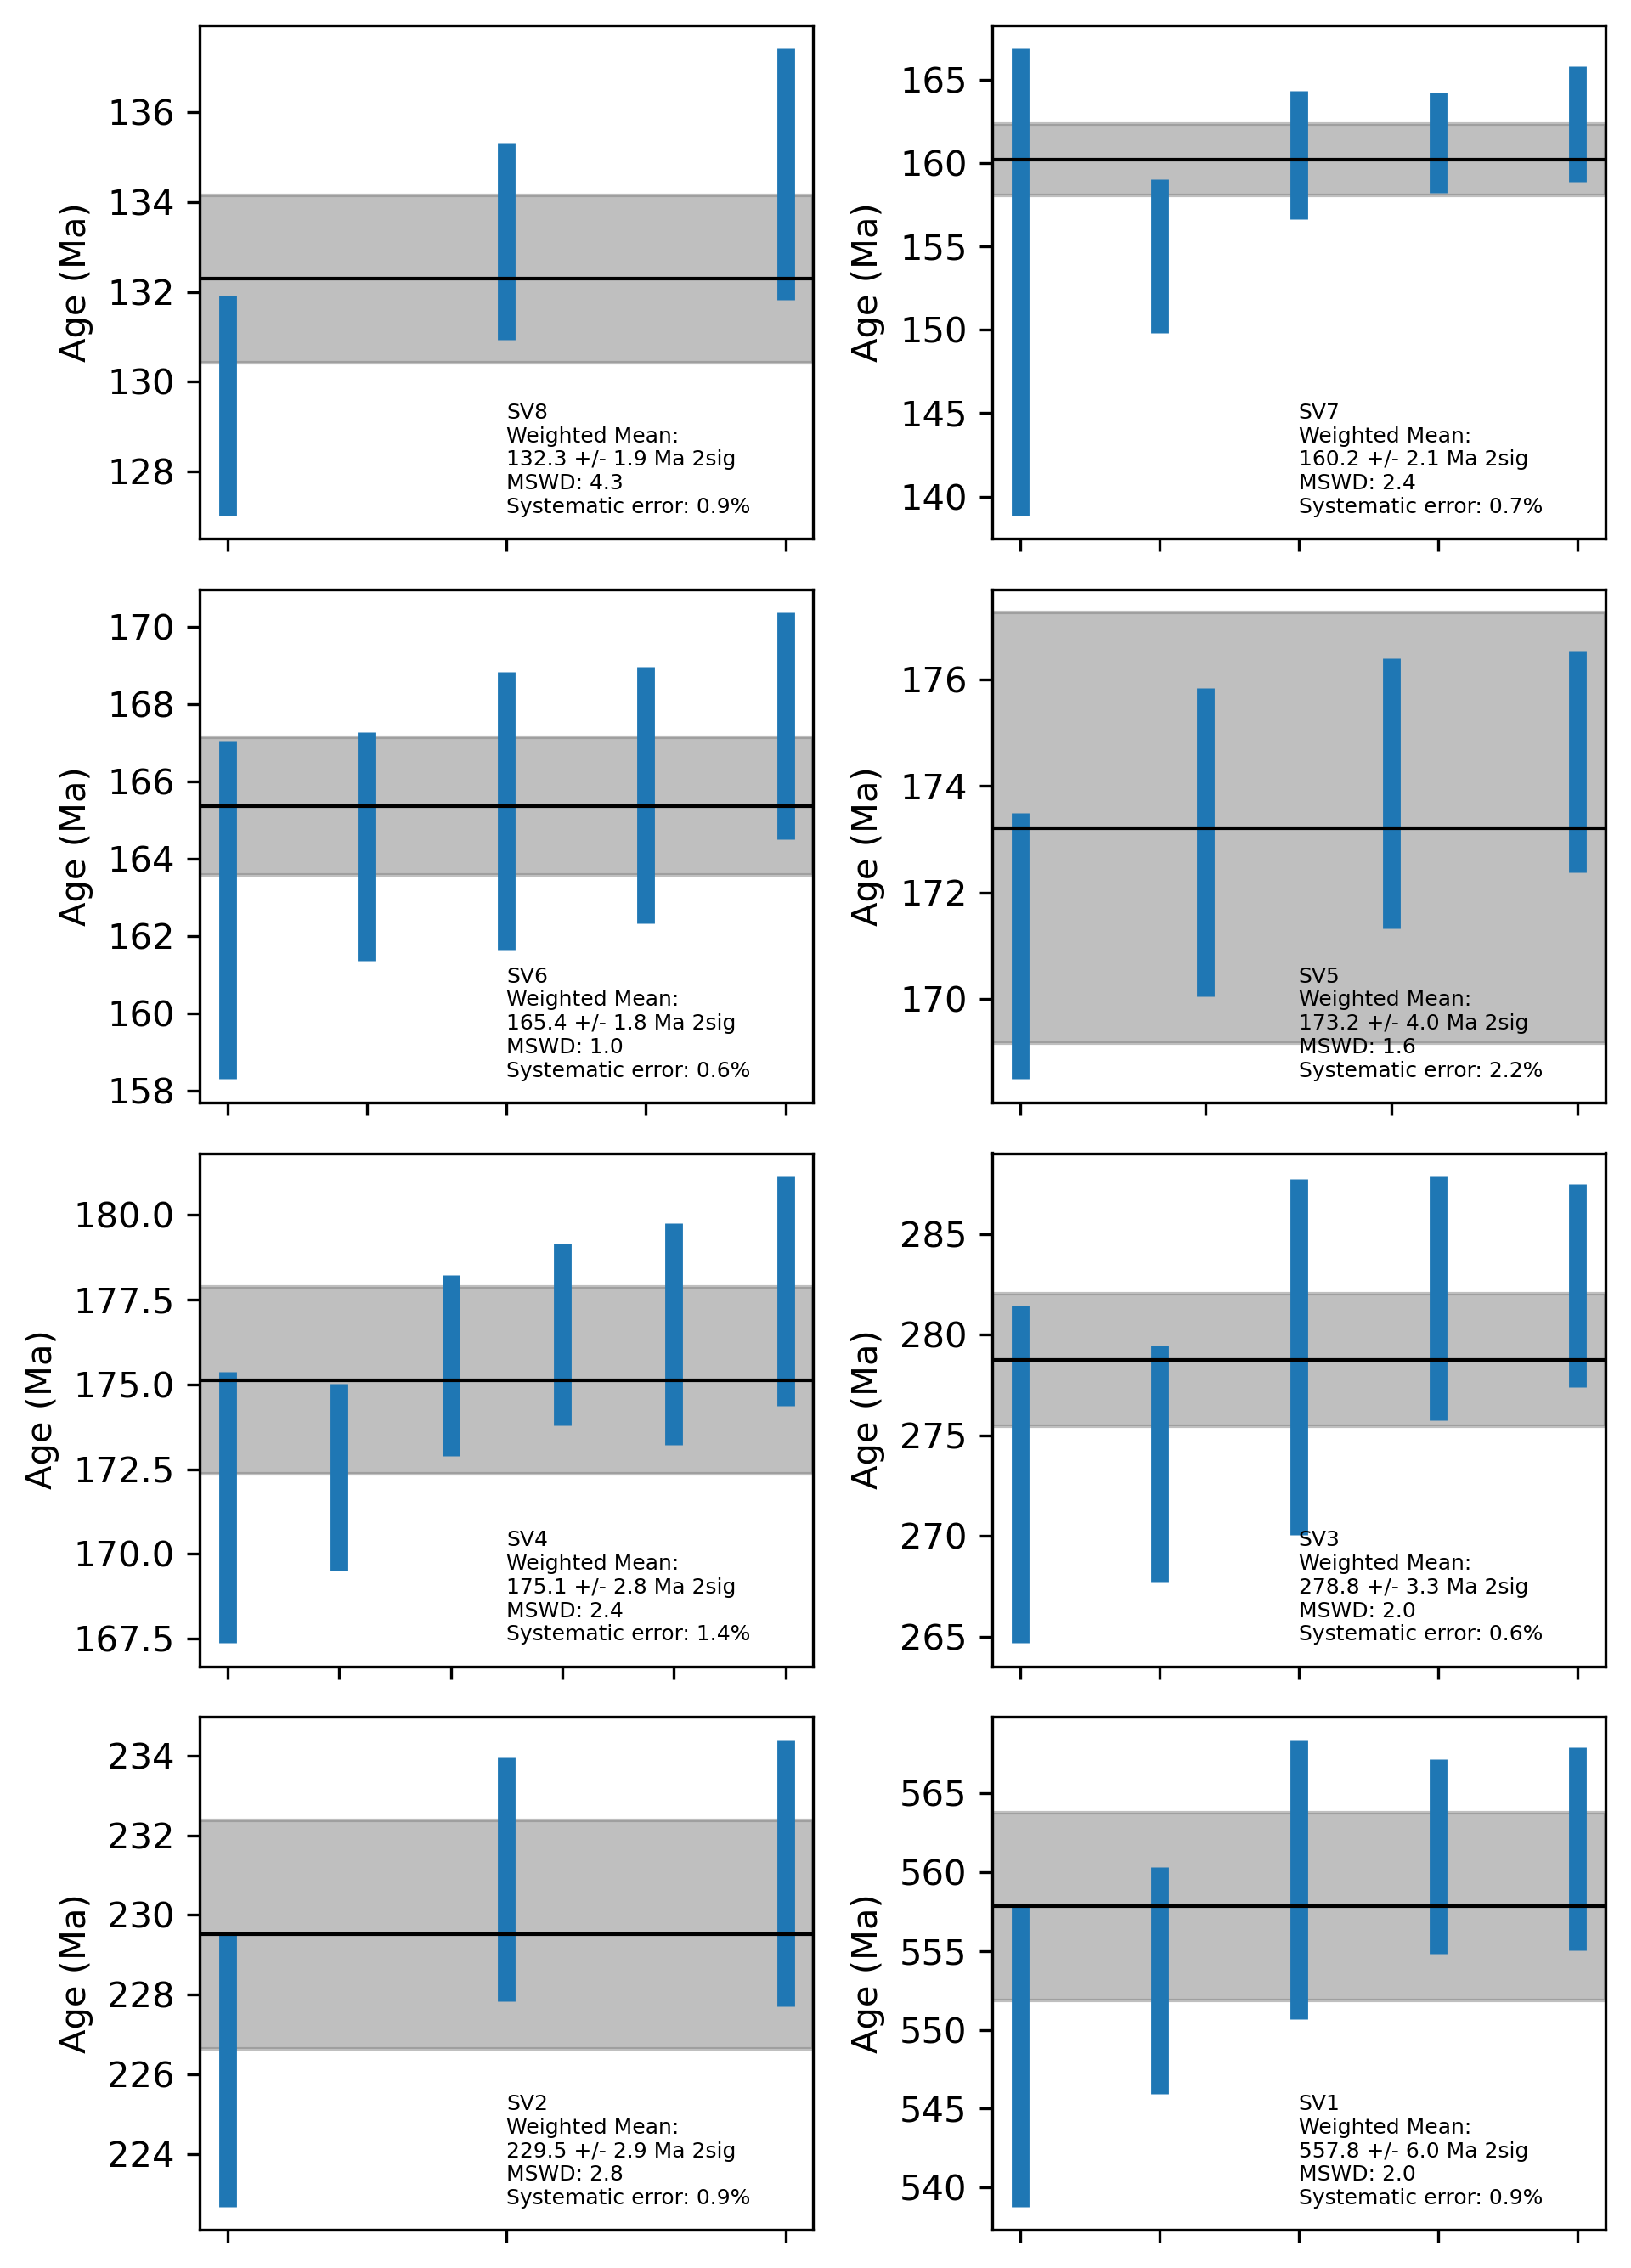

In [13]:
# Plot MDAs
fig, axs = plt.subplots(4,2,dpi=300,figsize=(6.5,9))

for k,smp in enumerate(sv_samples):
    smp.plot_mda(axs.flat[k],syst_error=True)

plt.tight_layout()

fig.savefig('sv_mda_plots.pdf')

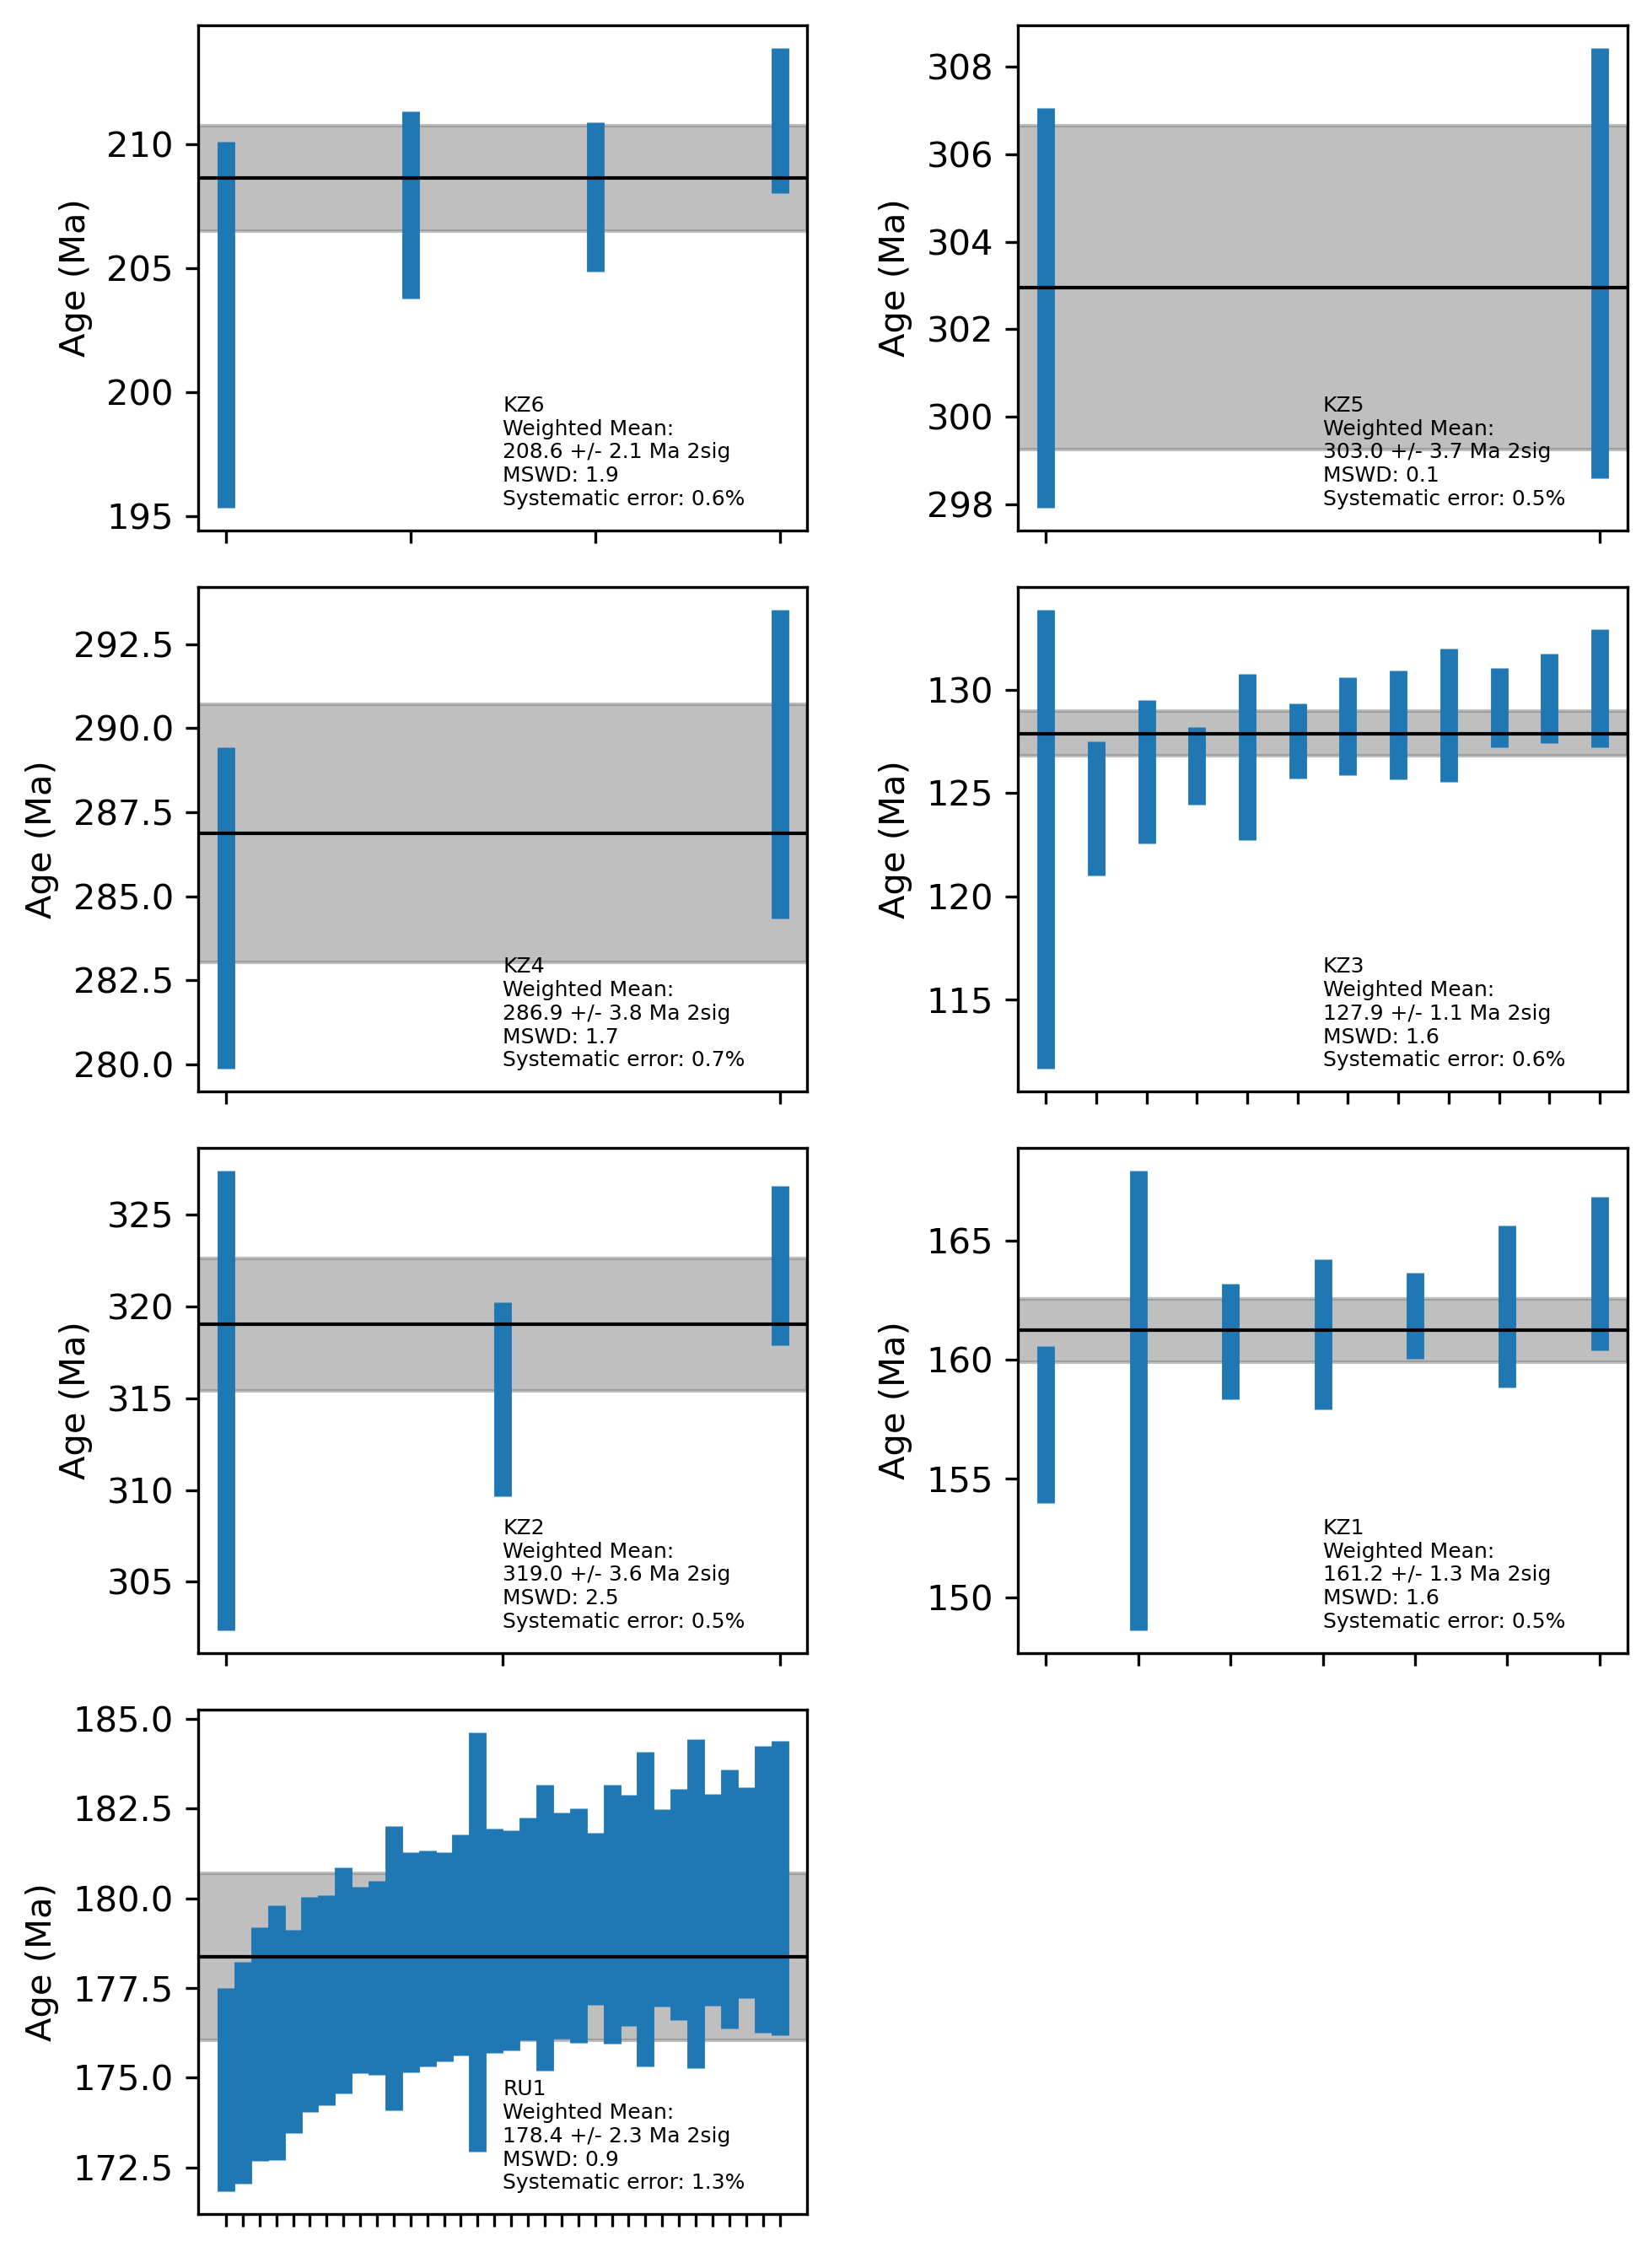

In [14]:
# Plot MDAs
fig, axs = plt.subplots(4,2,dpi=300,figsize=(6.5,9))

for k,smp in enumerate(kz_samples+ru):
    smp.plot_mda(axs.flat[k],syst_error=True)

axs.flat[7].remove()
plt.tight_layout()

fig.savefig('kz_mda_plots.pdf')

Converting...
Propagating systematic error -  1.0 
Original error:  5.507740039125093
Converting...
Propagating systematic error -  0.8 
Original error:  1.2754837999005275
Converting...
Propagating systematic error -  0.8 
Original error:  5.618762700902858
Converting...
Propagating systematic error -  0.9 
Original error:  2.936074912180768
Converting...
Propagating systematic error -  0.9 
Original error:  6.582574014764291


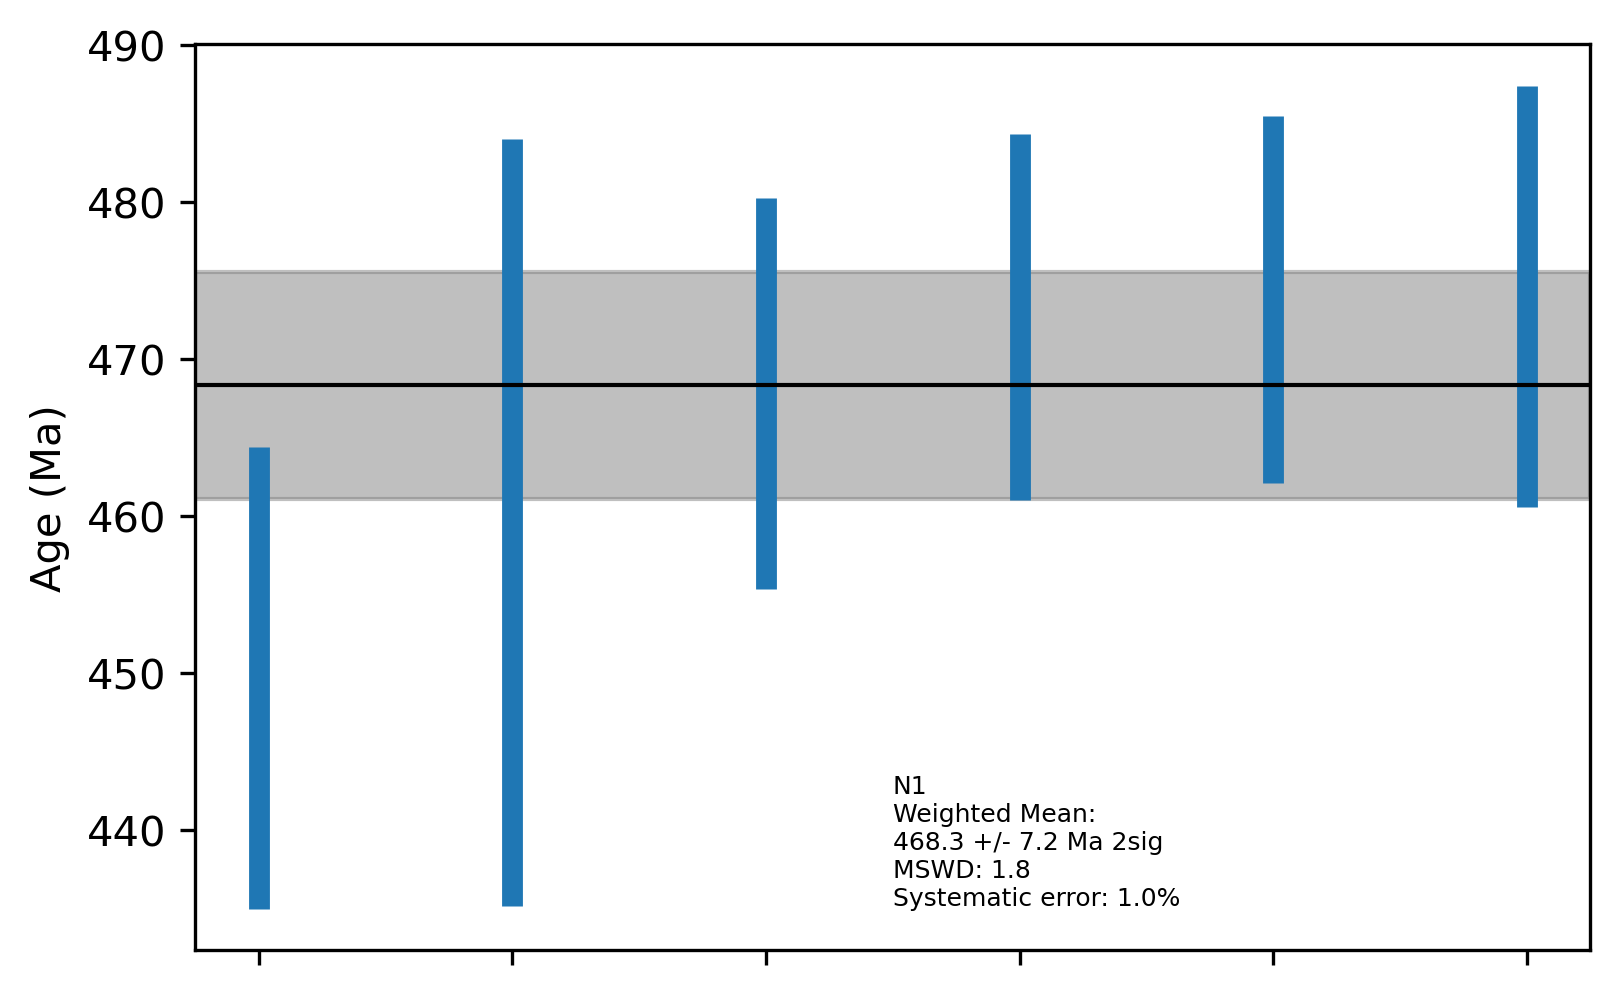

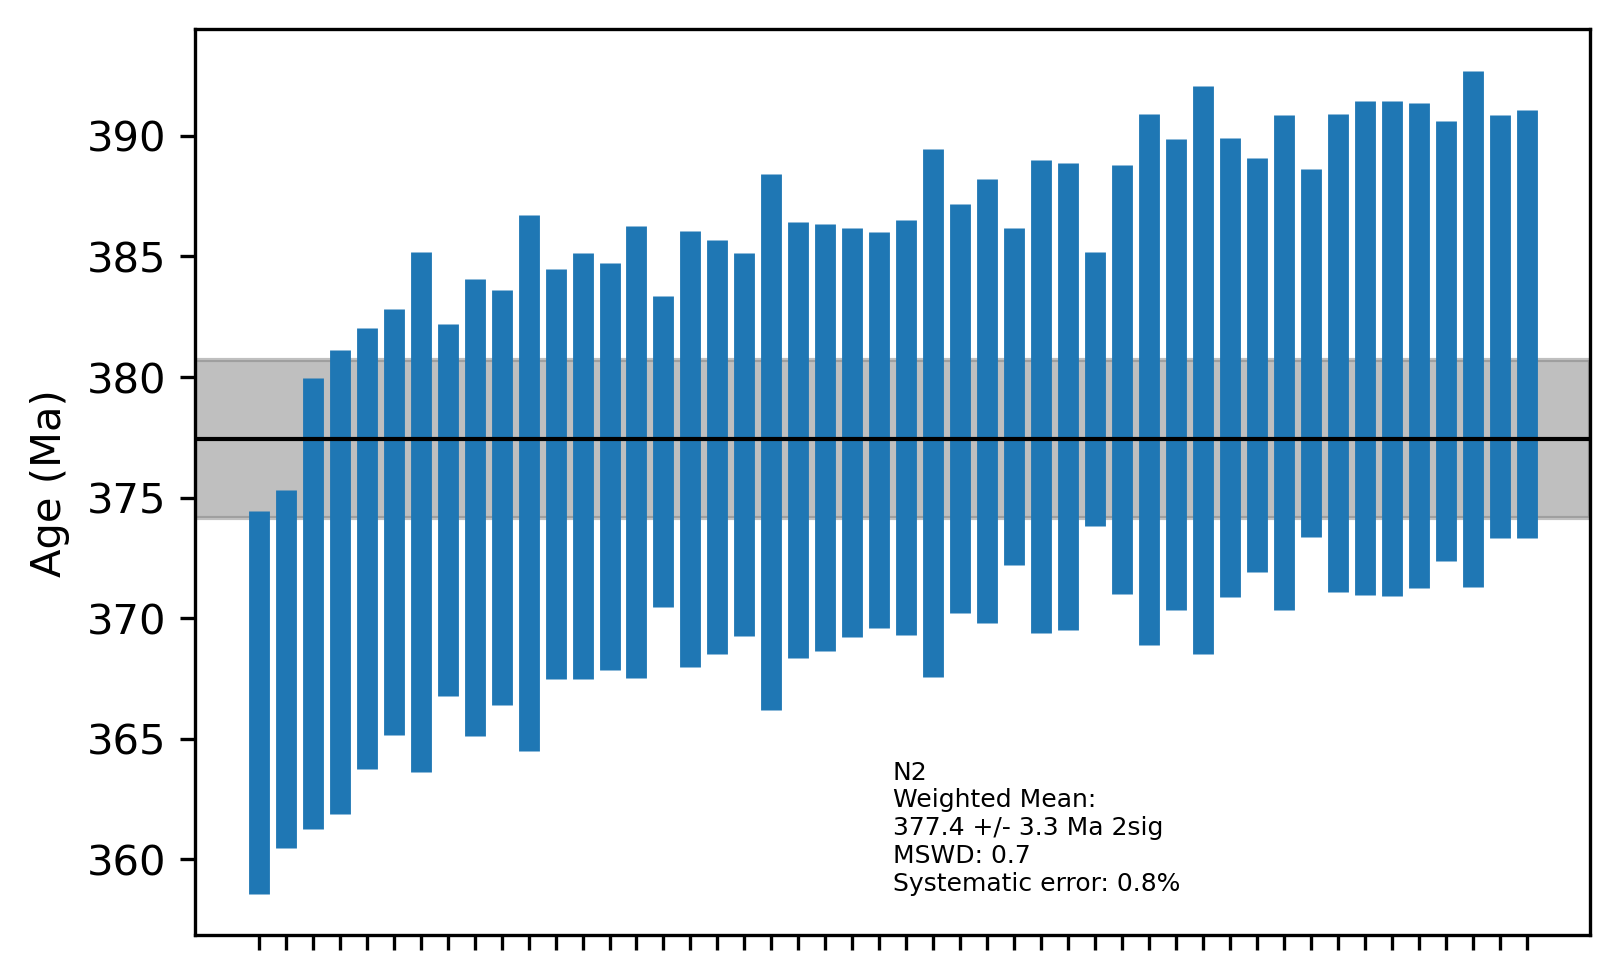

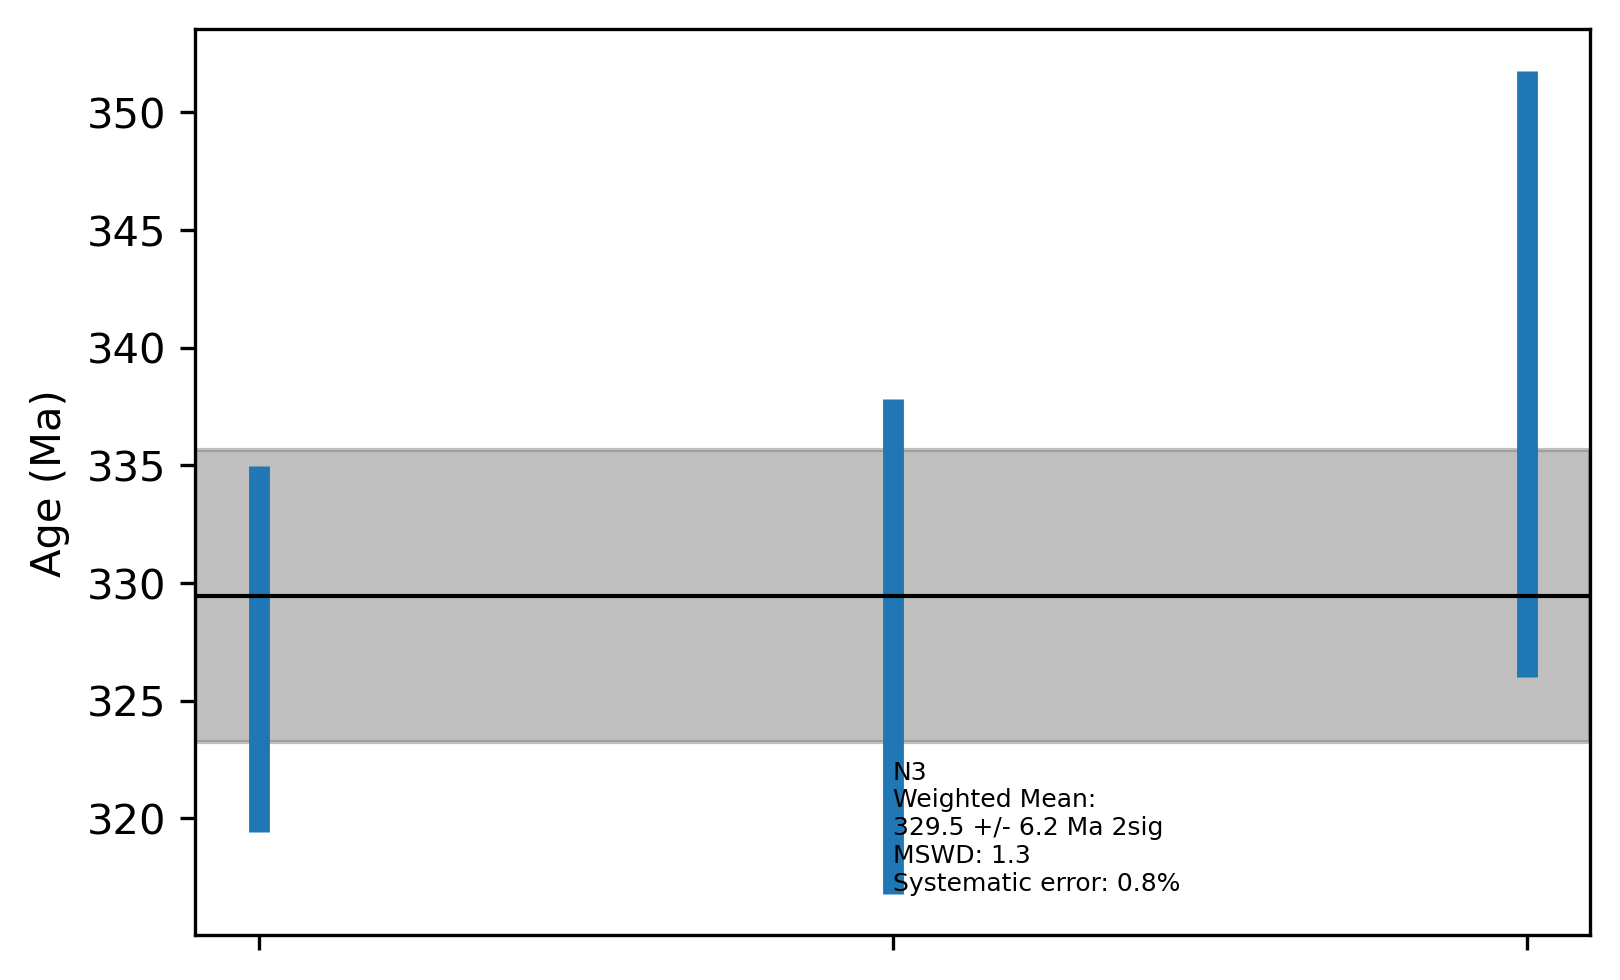

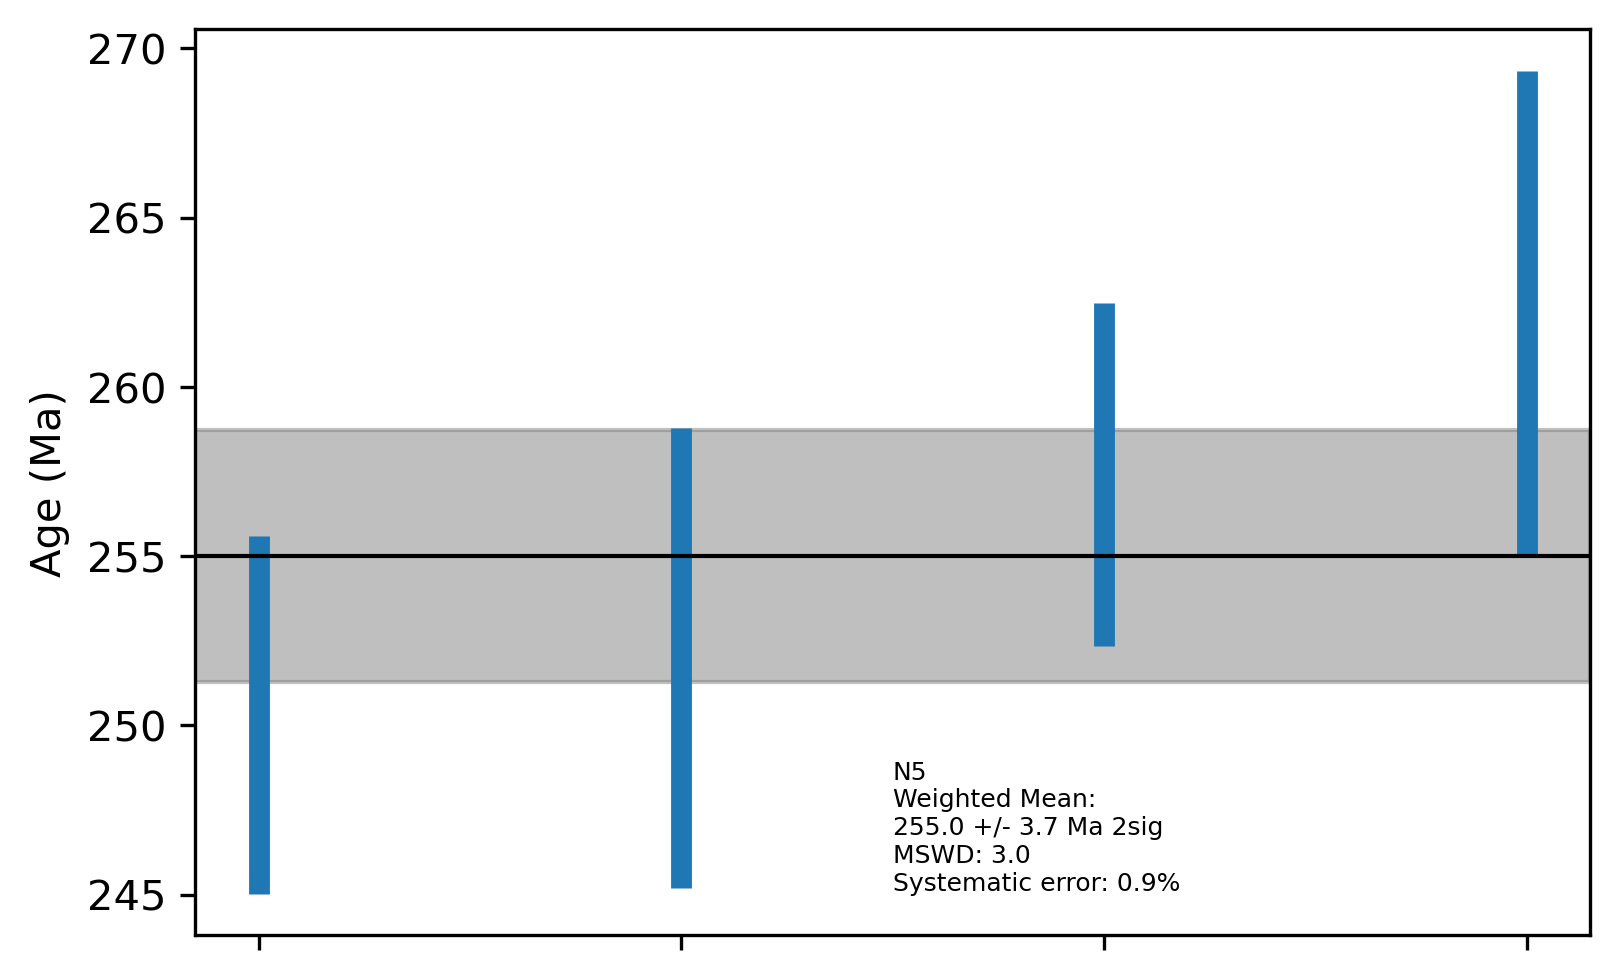

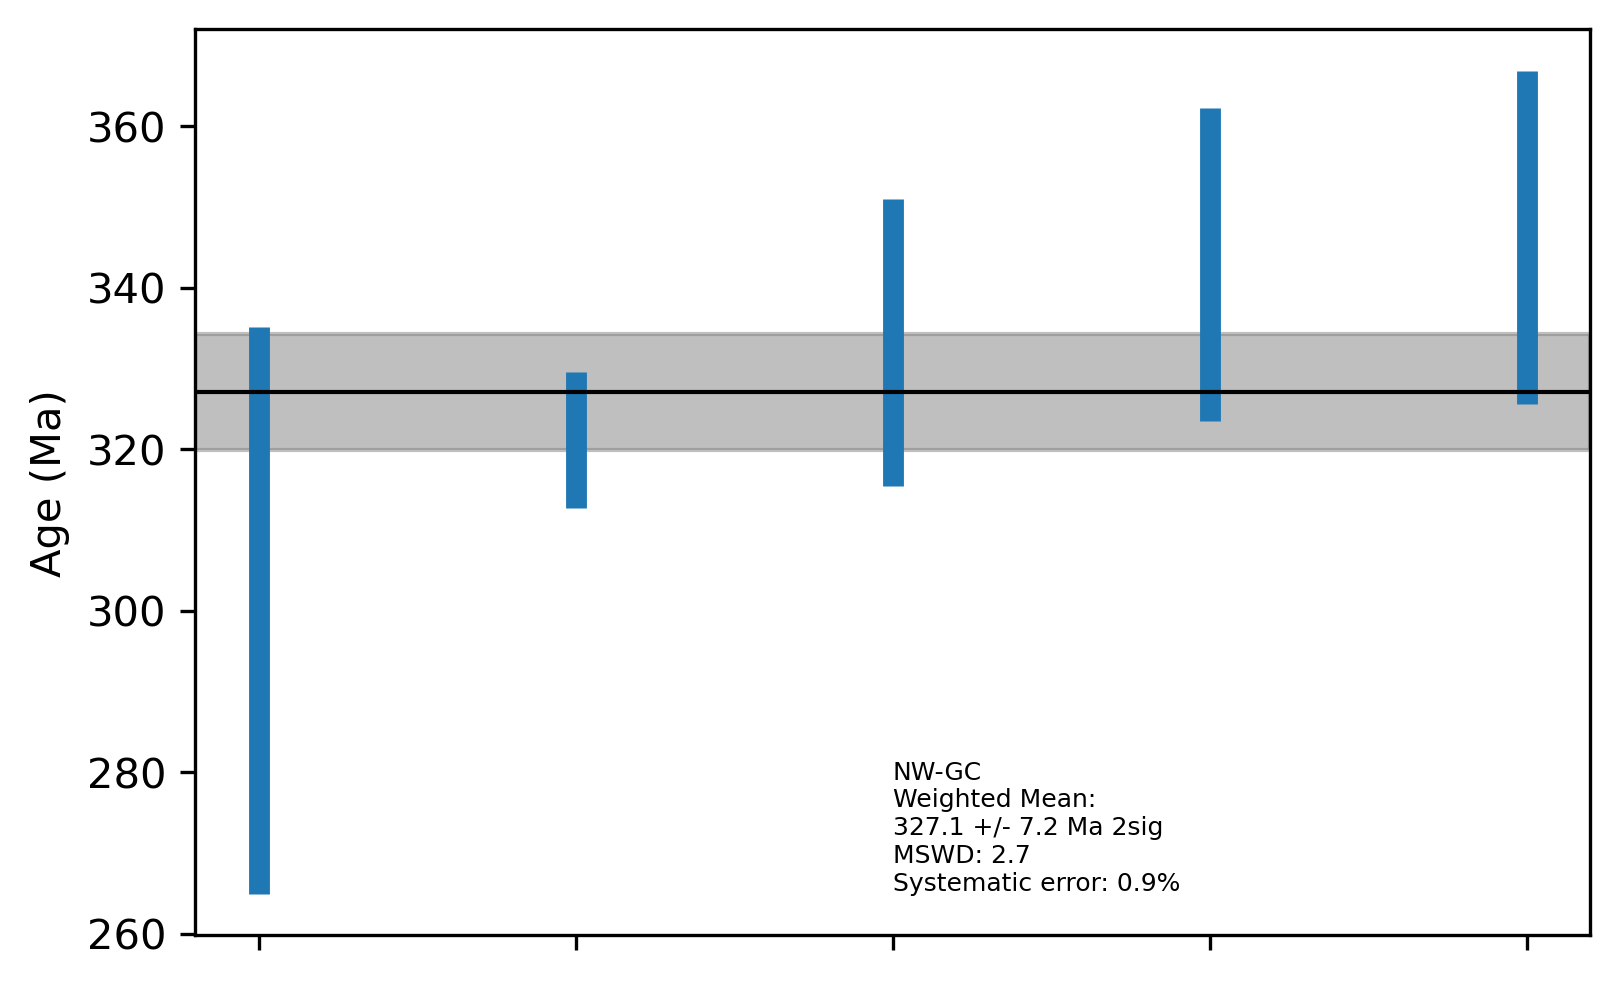

In [15]:
# Redo MDAs for old samples

syst_238 = {'NW-GC':0.9,'N1':1.0,'N2':0.8,'N3':0.8,'N5':0.9}

# Need to change discordance filter age to 600?
for smp in samples:
    if smp.name in ['NW-GC','N1','N2','N3','N5']:
        smp.calc_bestage(col_238='238/206 U-Pb Age',col_207='206/207 Pb Age',err_238='238 Error',err_207='206 Error',use_err=True,err_lev='1sig',
        disc_cutoff=20,disc_age_cutoff=600)
        smp.convert_1sigto2sig()
        smp.syst_238 = syst_238[smp.name]
        smp.calc_mda(systematic=True)
        age_errors = pd.concat([smp.bestage,smp.besterror],axis=1).dropna(how='any')
        ages_sorted = age_errors.sort_values(by=['Best Age'],ignore_index=True)
        smp.ysg = ages_sorted.iloc[0,0]
        smp.ysg_err = ages_sorted.iloc[0,1]

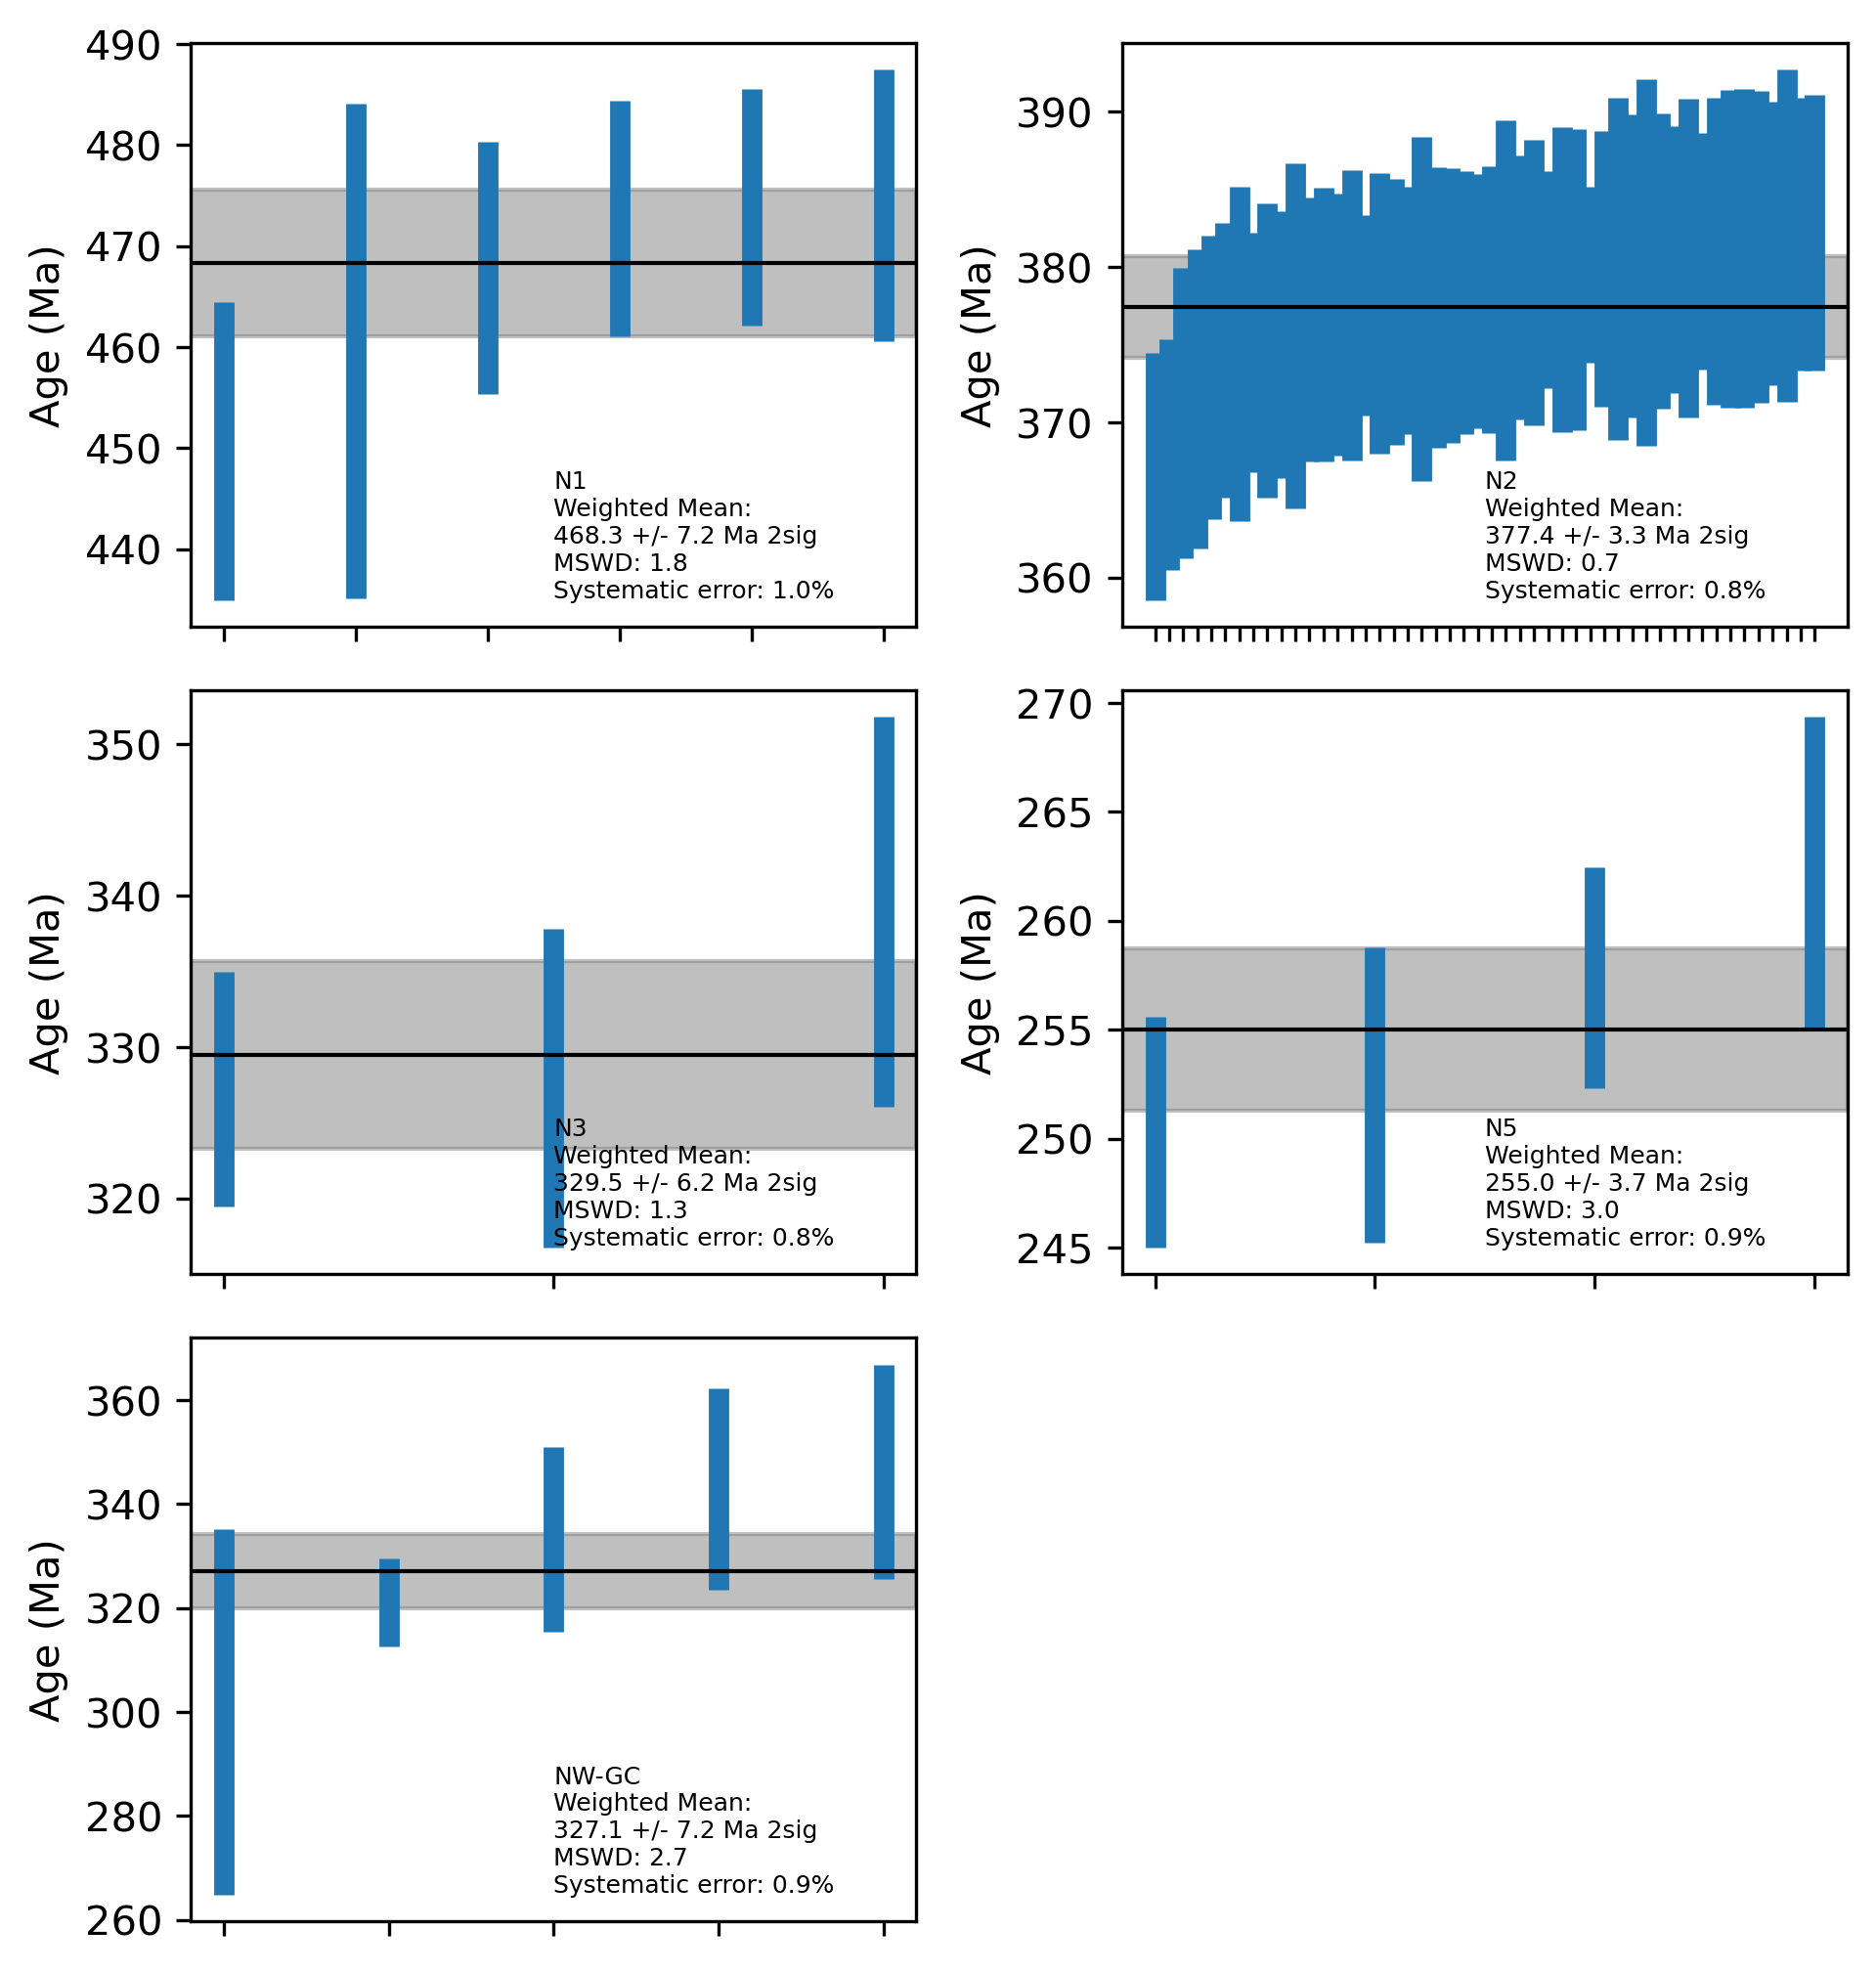

In [16]:
# Plot MDAs
fig, axs = plt.subplots(3,2,dpi=300,figsize=(6.5,9*0.75))

old_smps = [smp for smp in samples if smp.name in ['NW-GC','N1','N2','N3','N5']]

for k,smp in enumerate(old_smps):
    smp.plot_mda(axs.flat[k],syst_error=True)

axs.flat[5].remove()
plt.tight_layout()

fig.savefig('old_mda_plots.pdf')

In [17]:
def plot_fault_block(smps,save=False,filename=None,mda=True,plot_mapped=False,jcarb=False,mpeaks=False,**kwargs):
    
    nplots = len(smps)
    height = nplots*1.5
    
    
    if len(smps)==1:
        fig,axs = plt.subplots(nplots,dpi=300,figsize=(7.5,height))
        smp = smps[0]
        smp.kde(ax=axs,**kwargs)
        axs.set_title(smp.name)
        axs.set_xlim(50,4000)

        if mda:
            mda_text = 'MDA: ' + str(round(smp.mda,1)) + ' ± ' + str(round(smp.mda_err,1))
            axs.text(0.02,0.3,mda_text,transform=axs.transAxes)
            ysg_text = 'YSG: ' + str(round(smp.ysg,1)) + ' ± ' + str(round(smp.ysg_err,1))
            axs.text(0.02,0.1,ysg_text,transform=axs.transAxes)
    
    else:
        fig,axs = plt.subplots(nplots,dpi=300,figsize=(7.5,height),sharex=True)
        for k,smp in enumerate(smps):
            smp.kde(ax=axs[k],**kwargs)
            axs[k].set_title(smp.name)
            axs[k].set_xlim(50,4000)
            
            if mda:
                mda_text = 'MDA: ' + str(round(smp.mda,1)) + ' ± ' + str(round(smp.mda_err,1))
                axs[k].text(0.02,0.3,mda_text,transform=axs[k].transAxes)
                ysg_text = 'YSG: ' + str(round(smp.ysg,1)) + ' ± ' + str(round(smp.ysg_err,1))
                axs[k].text(0.02,0.1,ysg_text,transform=axs[k].transAxes)

            if plot_mapped:
                trans = axs[k].get_xaxis_transform()
                axs[k].plot([smp.mapped_age[0],smp.mapped_age[1]],[0.02,0.02],color='gray',linewidth=2,clip_on=False,transform=trans)
                axs[k].set_ylim(bottom=0)

            if jcarb:
                ejmin = 174.1
                ejmax = 201.3

                lcarbmin = 298.9
                lcarbmax = 323.2

                axs[k].axvline(ejmax,linestyle='--',color='navy',zorder=0)
                axs[k].axvline(ejmin,linestyle='--',color='navy',zorder=0)
                axs[k].axvline(lcarbmax,linestyle='--',color='purple',zorder=0)
                axs[k].axvline(lcarbmin,linestyle='--',color='purple',zorder=0)
            
            if mpeaks:
                peaks = [170,240,300,450,2000,2600]
                for peak in peaks:
                    axs[k].axvline(peak,linestyle='--',color='darkorange',zorder=0)
                

    plt.tight_layout()
    
    if save == True:
        fig.savefig(filename)
    
    return(smps)

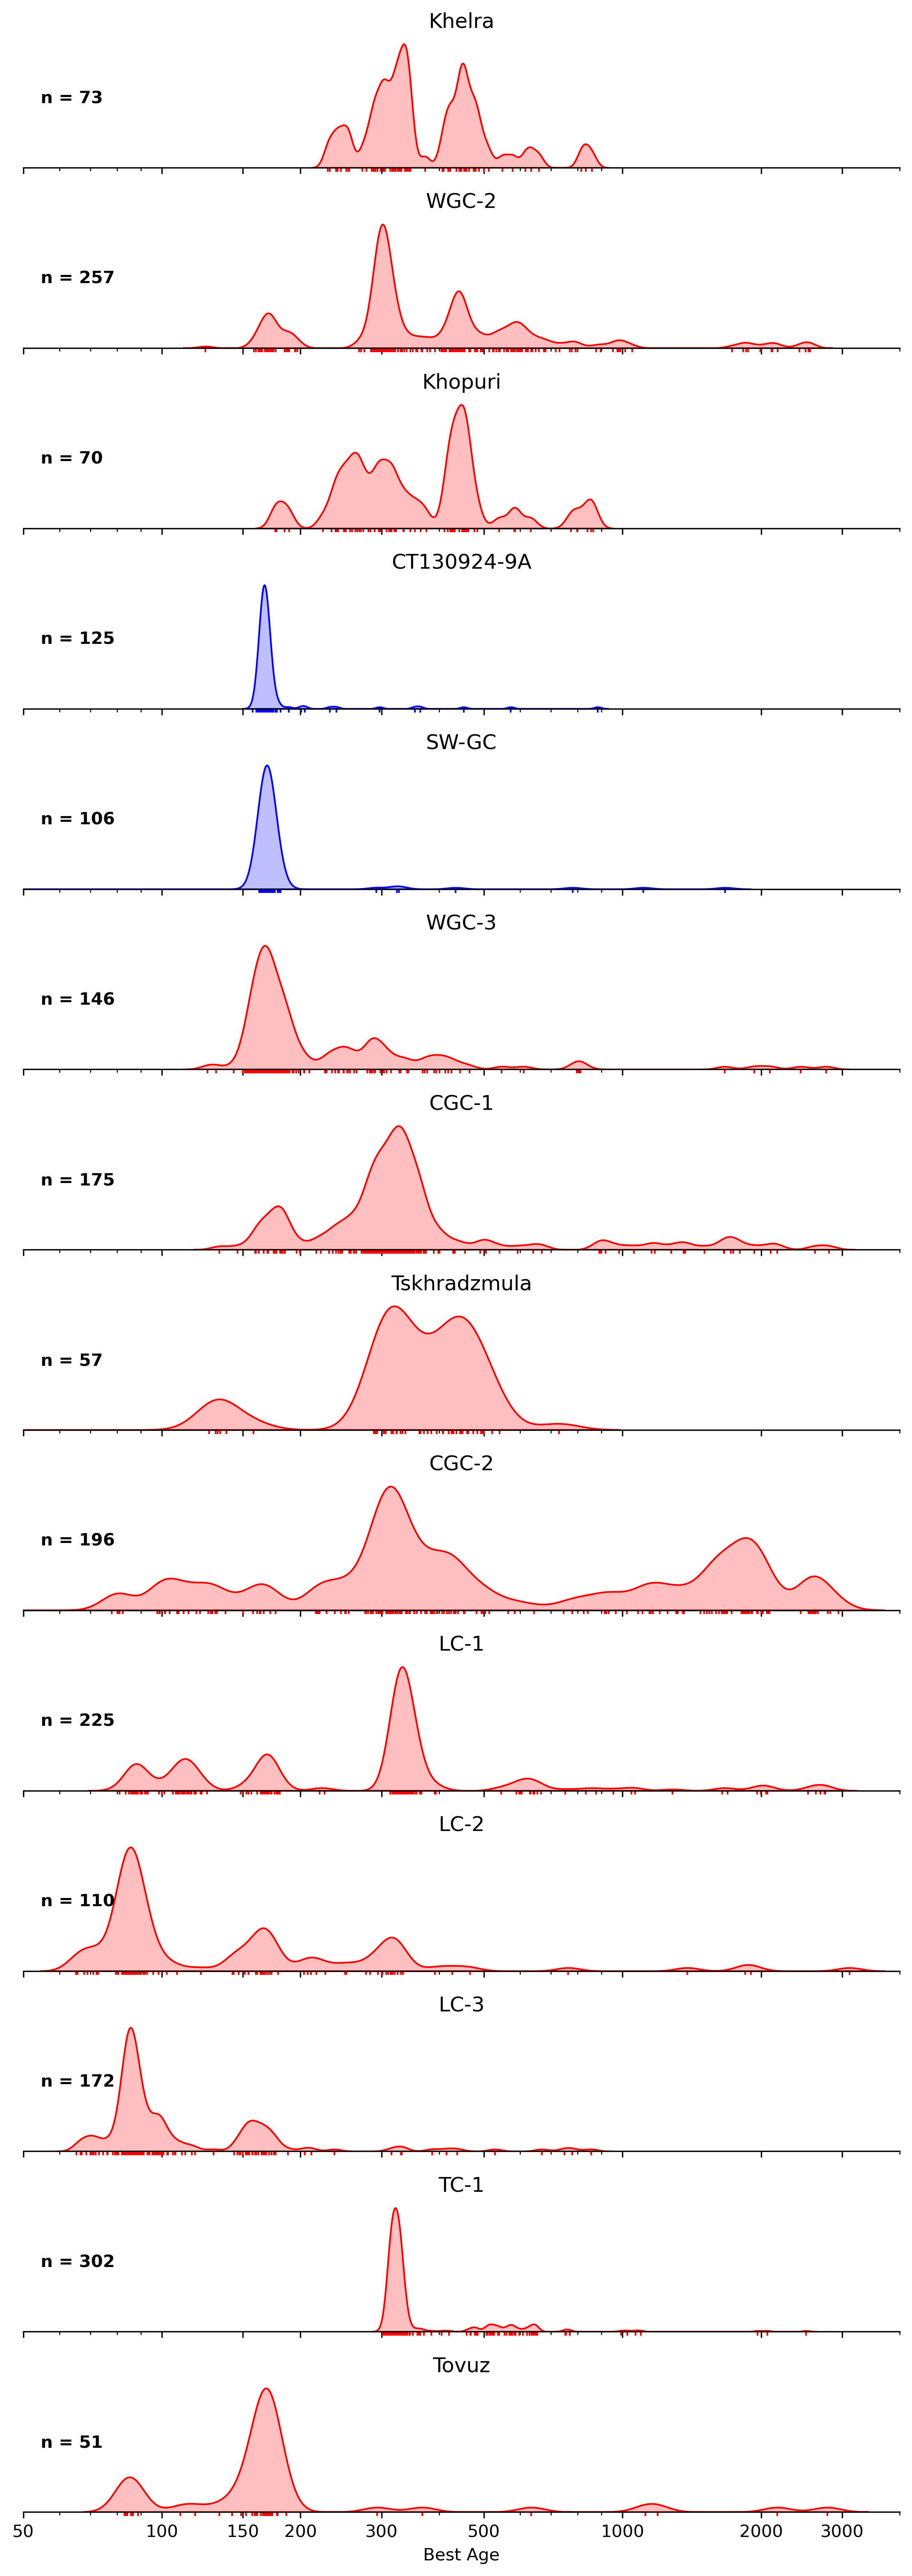

In [18]:
dizi_names = ['Khelra','WGC-2']
idliani_names = ['Khopuri']
jvari_names = ['SW-GC','WGC-3','CT130924-9A']
gvpas_names = ['Tskhradzmula','CGC-1']
ana_names = ['CGC-2']

lc_names = ['LC-1','LC-2','LC-3','TC-1','Tovuz']

dizi_smps = [smp for smp in samples if smp.name in dizi_names]
idliani_smps = [smp for smp in samples if smp.name in idliani_names]
jvari_smps = [smp for smp in samples if smp.name in jvari_names]
gvpas_smps = [smp for smp in samples if smp.name in gvpas_names]
ana_smps = [smp for smp in samples if smp.name in ana_names]
lc_smps = [smp for smp in samples if smp.name in lc_names]

for smp in lc_smps:
    smp.bestage = smp.bestage[smp.bestage>65]

block = dizi_smps + idliani_smps + jvari_smps + gvpas_smps + ana_smps + lc_smps

ticks = [50,100,150,200,300,500,1000,2000,3000]
plot_fault_block(block,mda=False,bw_adjust=0.2,ticks=ticks,save=True,filename='supp_kdes.pdf')